In [130]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
from matplotlib import pyplot as plt

In [82]:
p = Path("./images/")

dirs = p.glob("*")

labels_dict = {"cat":0, "dog":1, "horse":2, "human":3}

image_data = []
labels = []
    
for folder_name in dirs:
    #print(folder_name)
    label = str(folder_name).split("/")[-1][:-1]

    
    for img_path in folder_name.glob("*.jpg"):
        #print(img_path)
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        
        image_data.append(img_array)
        labels.append(labels_dict[label])

In [83]:
print(len(image_data), len(labels))

808 808


In [84]:
# convert this data to numpy array
image_data = np.array(image_data, dtype="float32")/255.0
labels = np.array(labels)

print(image_data.shape, labels.shape)

(808, 32, 32, 3) (808,)


In [85]:
### visualise this data

In [86]:
def drawImg(img):
    from matplotlib import pyplot as plt
    plt.imshow(img)
    return

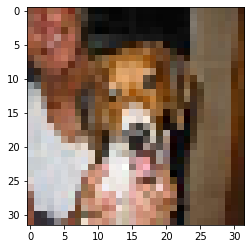

In [87]:
drawImg(image_data[0])

In [88]:
## random shuffle our data

In [89]:
import random

In [90]:
combined = list(zip(image_data, labels))
random.shuffle(combined)

image_data[:], labels[:] = zip(*combined)

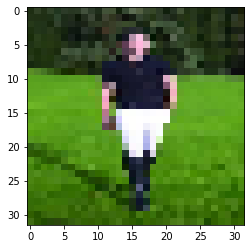

In [91]:
drawImg(image_data[0])

In [92]:
### svm classifier

In [93]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self, W, b, X, Y):
        loss = 0.0
        
        loss += 0.5*np.dot(W, W.T)
        
        m = X.shape[0]
        for i in range(m):
            ti = Y[i]*(np.dot(W, X[i].T) + b)
            loss += self.C * max(0, 1-ti)
            
        return loss[0][0]
    
    def fit(self, X, Y, batch_size=100, learning_rate=0.001, maxItr=300):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        # init model parameters
        W = np.zeros((1,no_of_features))
        b = 0
        
        print(self.hingeLoss(W,b,X,Y))
        
        # training from here
        # update weight and bias rule
        losses = []
        
        for i in range(maxItr):
            #training loop
            l = self.hingeLoss(W,b,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            # batch gradient with random suffling
            for batch_start in range(0,no_of_samples, batch_size):
                #assume 0 gradient for the batch
                gradW = 0
                gradb = 0
                
                # iterate over all examples in the mini batch
                for j in range(batch_start, batch_start+batch_size):
                    if j < no_of_samples:
                        i = ids[j]
                        
                        ti = Y[i]*(np.dot(W, X[i].T) + b)
                        if ti > 1:
                            gradW += 0
                            gradb += 0
                        else:
                            gradW += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                # gradient for the batch us ready, now update w and b
                W = W - n*W + n*gradW
                b = b + n*gradb
                
        self.W = W
        self.b = b
        return W, b, losses

In [94]:
## we need to convert data for one to one classification

In [95]:
m = image_data.shape[0]
image_data = image_data.reshape(m,-1)
print(image_data.shape, labels.shape)

(808, 3072) (808,)


In [96]:
CLASSES = len(np.unique(labels))
print(CLASSES)

4


In [98]:
def classWiseData(x,y):
    data = {}
    
    for i in range(CLASSES):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [100]:
data = classWiseData(image_data, labels)

print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)

(202, 3072)
(202, 3072)
(202, 3072)
(202, 3072)


In [103]:
def getDataPairForSVM(d1,d2):
    # combines data of two classes into a single matrix
    l1,l2 = d1.shape[0], d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples, features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1, :] = d1
    data_pair[l1:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair, data_labels

In [105]:
### train NC2 SVM's part

In [106]:
mySVM = SVM()

In [134]:
def trainSVMs(x,y):
    svm_classifiers = {}
    for i in range(CLASSES):
        svm_classifiers[i] = {}
        for j in range(i+1, CLASSES):
            xpair, ypair = getDataPairForSVM(data[i], data[j])
            wts, b, loss = mySVM.fit(xpair, ypair, learning_rate=0.00001, maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            
    return svm_classifiers

In [135]:
svm_classifiers = trainSVMs(image_data, label)

404.0
404.0
404.0
404.0
404.0
404.0


In [136]:
# parameters
cats_dogs = svm_classifiers[0][1]
cats_huans = svm_classifiers[0][3]
print(cats_dogs[0].shape, cats_dogs[1])

(1, 3072) -0.07713999999999989


In [137]:
### prediction

In [138]:
def binaryPredict(x,w,b):
    z = np.dot(x, w.T) + b
    
    if z > 0: return 1
    else: return -1

In [139]:
def predict(x):
    count = np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1, CLASSES):
            w,b = svm_classifiers[i][j]
            
            #take the majority vote
            z = binaryPredict(x,w,b)
            
            if z == 1:
                count[j] += 1
            else: count[i] += 1
          
    #print(count)
    final_prediction = np.argmax(count)
    return final_prediction

In [140]:
print(predict(image_data[10]), labels[10])

1 2


In [141]:
def accuracy(x,y):
    count = 0
    
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction == y[i]):
            count += 1
        
    return count/x.shape[0]

In [142]:
accuracy(image_data, labels)

0.5965346534653465

In [143]:
### checking different lr and mexItr

404.0


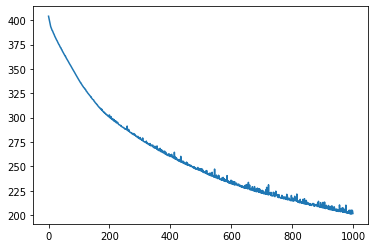

In [133]:
mySVM = SVM()
xp,yp = getDataPairForSVM(data[0], data[1])
w,b,loss = mySVM.fit(xp,yp, learning_rate=0.00001, maxItr=1000)
plt.plot(loss)

In [ ]:
### using sklearn

In [144]:
from sklearn import svm

In [145]:
svm_classifier = svm.SVC(kernel="linear", C=1.0)

In [146]:
svm_classifier.fit(image_data, labels)
svm_classifier.score(image_data, labels)

0.6373762376237624